# Pylops - Marchenko redatuming with joint datasets and missing sources

### Author: M.Ravasi

In this notebook we consider to extensions of the Marchenko inversion for joint datasets in the presence of missing sources

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import bicgstab, lsqr
from scipy.signal import convolve, fftconvolve, filtfilt, hilbert

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

import MarchenkoFunctions as MF

In [2]:
def callback(x, xtrue, prec, snr):
    x = prec * x
    x = x.reshape(xtrue.shape)
    snr.append(10*np.log10(np.linalg.norm(xtrue)**2/np.linalg.norm(x - xtrue)**2))

## Inputs

Input parameters 

In [3]:
path0='./datasets_new/'

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nfft = 2 ** 11      # number of fft samples
nstaper = 11        # source/receiver taper lenght
n_iter = 100        # iterations
    
jr = 3              # subsampling in r
jt = 5

Load input

Read and visualize geometry

In [4]:
# Receivers
r = np.loadtxt(path0 + 'r.dat', delimiter=',')
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = np.loadtxt(path0 + 's.dat', delimiter=',')
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = [1200, 1240]

# Geometry
nz = 401
oz = 0
dz = 4
z = np.arange(oz, oz + nz*dz, dz)

nx=751
ox=0
dx=4
x = np.arange(ox, ox + nx*dx, dx)

Read data

In [5]:
# time axis
ot=0
nt=1081
dt=0.0025
t = np.arange(ot,ot+nt*dt,dt)
t2 = np.concatenate([-t[::-1], t[1:]])
nt2 = len(t2)

# data
R_1=np.zeros((nt, ns, nr),'f')
R_2=np.zeros((nt, ns, nr),'f')
for isrc in range(ns-1):
    is_ = isrc*jr
    R_1[:,:,isrc]=np.loadtxt(path0 + 'dat1_' + str(is_) + '.dat', delimiter=',')
    R_2[:,:,isrc]=np.loadtxt(path0 + 'dat2_' + str(is_) + '.dat', delimiter=',')

R_1 = 2 * np.swapaxes(R_1,0,2)
R_2 = 2 * np.swapaxes(R_2,0,2)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R_1 = R_1*taper
R_2 = R_2*taper

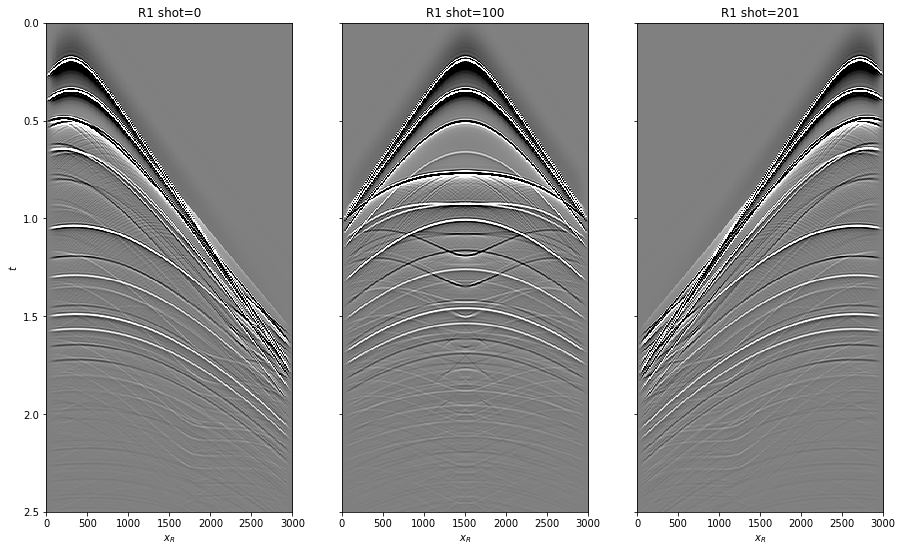

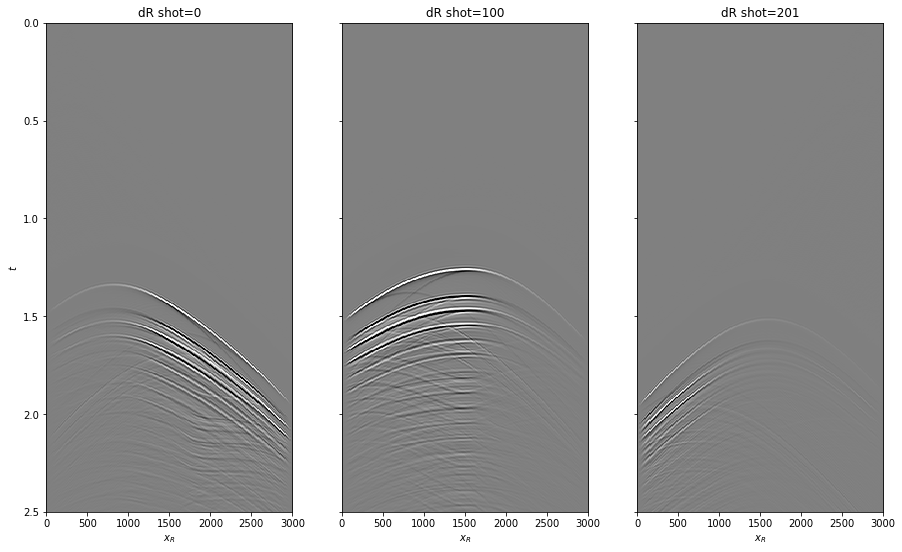

In [6]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R_1[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R1 shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(R_1[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R1 shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0)
axs[2].imshow(R_1[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R1 shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(2.5, 0);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow((R_1-R_2)[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('dR shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow((R_1-R_2)[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('dR shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0)
axs[2].imshow((R_1-R_2)[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('dR shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(2.5, 0);

Read wavelet and traveltime 

In [7]:
wav = np.loadtxt(path0 + 'wav.dat', delimiter=',')
    
trav_eik = np.loadtxt(path0 + 'trav.dat', delimiter=',')
trav_eik = np.reshape(trav_eik,(nz, ns, nx))

## Marchenko preparation

Create first arrival

In [8]:
# direct arrival window - traveltime
directVS = trav_eik[MF.find_closest(vs[1],z)-1,:,MF.find_closest(vs[0],x)-1]
directVS_off = directVS - toff

G0sub = directwave(wav, directVS, nt, dt, nfft=2**11)

Create window

In [9]:
# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)

Create analytical direct wave

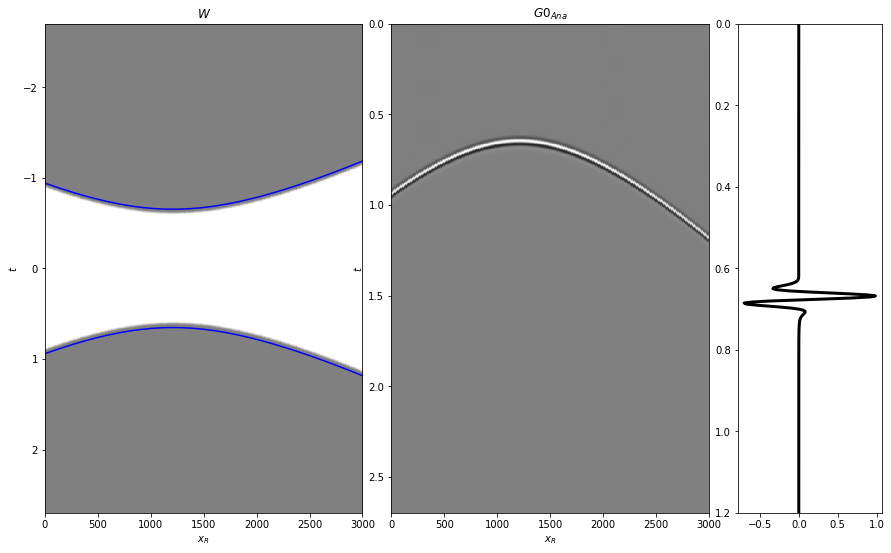

In [10]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(w.T, cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.plot(r[0], directVS,'b'),ax1.plot(r[0], -directVS,'b')
ax1.set_title(r'$W$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Indipendent Marchenko with full sources

Let's start by creating benchmark responses

In [11]:
Rtwosided_1 = np.concatenate((np.zeros((nr, ns, nt-1)), R_1), axis=-1)
R1twosided_1 = np.concatenate((np.flip(R_1, axis=-1), np.zeros((nr, ns, nt-1))), axis=-1)
Rtwosided_fft_1 = np.fft.rfft(Rtwosided_1, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft_1 = Rtwosided_fft_1[...,:nfmax]
R1twosided_fft_1 = np.fft.rfft(R1twosided_1, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
R1twosided_fft_1 = R1twosided_fft_1[...,:nfmax]

Rtwosided_2 = np.concatenate((np.zeros((nr, ns, nt-1)), R_2), axis=-1)
R1twosided_2 = np.concatenate((np.flip(R_2, axis=-1), np.zeros((nr, ns, nt-1))), axis=-1)
Rtwosided_fft_2 = np.fft.rfft(Rtwosided_2, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft_2 = Rtwosided_fft_2[...,:nfmax]
R1twosided_fft_2 = np.fft.rfft(R1twosided_2, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
R1twosided_fft_2 = R1twosided_fft_2[...,:nfmax]

In [12]:
# Operators
Rop1 = MDC(Rtwosided_fft_1, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
R1op1 = MDC(R1twosided_fft_1, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')

Rop2 = MDC(Rtwosided_fft_2, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
R1op2 = MDC(R1twosided_fft_2, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
Wsop = Diagonal(w.flatten())
Wrop = Diagonal(w.flatten())
Iop = Identity(nr*(2*nt-1))

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T), np.zeros((nr, nt-1))), axis=-1)
    
# Operators   
Mop1 = VStack([HStack([Iop, -1*Wsop*Rop1]),
               HStack([-1*Wsop*R1op1, Iop])])*BlockDiag([Wrop, Wrop])
Mop2 = VStack([HStack([Iop, -1*Wsop*Rop2]),
               HStack([-1*Wsop*R1op2, Iop])])*BlockDiag([Wrop, Wrop])

Gop1 = VStack([HStack([Iop, -1*Rop1]),
               HStack([-1*R1op1, Iop])])
Gop2 = VStack([HStack([Iop, -1*Rop2]),
               HStack([-1*R1op2, Iop])])

dottest(Gop1, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop1, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=856.626932 - u^T(Op^Tv)=856.626932
Dot test passed, v^T(Opu)=393.730467 - u^T(Op^Tv)=393.730467


In [13]:
# RTM
p0_1_minus_l2indip = Rop1 * fd_plus.flatten()
p0_1_minus_l2indip = p0_1_minus_l2indip.reshape(ns, (2*nt-1))

p0_2_minus_l2indip = Rop2 * fd_plus.flatten()
p0_2_minus_l2indip = p0_2_minus_l2indip.reshape(ns, (2*nt-1))

# Data
d1 = Wsop*Rop1*fd_plus.flatten()
d1 = np.concatenate((d1.reshape(ns, 2*nt-1), np.zeros((ns, 2*nt-1))))
d2 = Wsop*Rop2*fd_plus.flatten()
d2 = np.concatenate((d2.reshape(ns, 2*nt-1), np.zeros((ns, 2*nt-1))))

# Inverse
f1_1_l2indip = lsqr(Mop1, d1.flatten(), iter_lim=20, show=True)[0]
f1_1_l2indip = f1_1_l2indip.reshape(2*nr, nt2)

f1_2_l2indip = lsqr(Mop2, d2.flatten(), iter_lim=20, show=True)[0]
f1_2_l2indip = f1_2_l2indip.reshape(2*nr, nt2)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   868722 rows  and   868722 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.277e+01  5.277e+01    1.0e+00  2.0e-02
     1  0.00000e+00   2.335e+01  2.335e+01    4.4e-01  9.8e-01   1.2e+00  1.0e+00
     2  0.00000e+00   1.344e+01  1.344e+01    2.5e-01  4.0e-01   1.9e+00  2.2e+00
     3  0.00000e+00   1.056e+01  1.056e+01    2.0e-01  2.8e-01   2.3e+00  3.4e+00
     4  0.00000e+00   8.256e+00  8.256e+00    1.6e-01  2.7e-01   2.7e+00  5.1e+00
     5  0.00000e+00   6.564e+00  6.564e+00    1.2e-01  2.0e-01   3.0e+00  6.9e+00
     6  0.00000e+00   5.587e+00  5.587e+00    1.1e-01  1.7e-01   3.3e+00  8.6e+00
     7  0.00000e+00   4.669e+00  4.669e+00    8.8e-02  1.7e-01   3.6e+00  1.1e+01
     8  0.00000e+00   3.926e

In [14]:
f1_1_tot_l2indip = f1_1_l2indip + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus))
f1_2_tot_l2indip = f1_2_l2indip + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus))

g_1_tot_l2indip = Gop1*f1_1_tot_l2indip.flatten()
g_1_tot_l2indip = g_1_tot_l2indip.reshape(2*ns, (2*nt-1))
g_2_tot_l2indip = Gop2*f1_2_tot_l2indip.flatten()
g_2_tot_l2indip = g_2_tot_l2indip.reshape(2*ns, (2*nt-1))

f1_1_minus_l2indip, f1_1_plus_l2indip =  f1_1_tot_l2indip[:nr], f1_1_tot_l2indip[nr:]
f1_2_minus_l2indip, f1_2_plus_l2indip =  f1_2_tot_l2indip[:nr], f1_2_tot_l2indip[nr:]
g_1_minus_l2indip, g_1_plus_l2indip =  -g_1_tot_l2indip[:ns], np.fliplr(g_1_tot_l2indip[ns:])
g_2_minus_l2indip, g_2_plus_l2indip =  -g_2_tot_l2indip[:ns], np.fliplr(g_2_tot_l2indip[ns:])

g_1_tot_l2indip = g_1_minus_l2indip + g_1_plus_l2indip
g_2_tot_l2indip = g_2_minus_l2indip + g_2_plus_l2indip

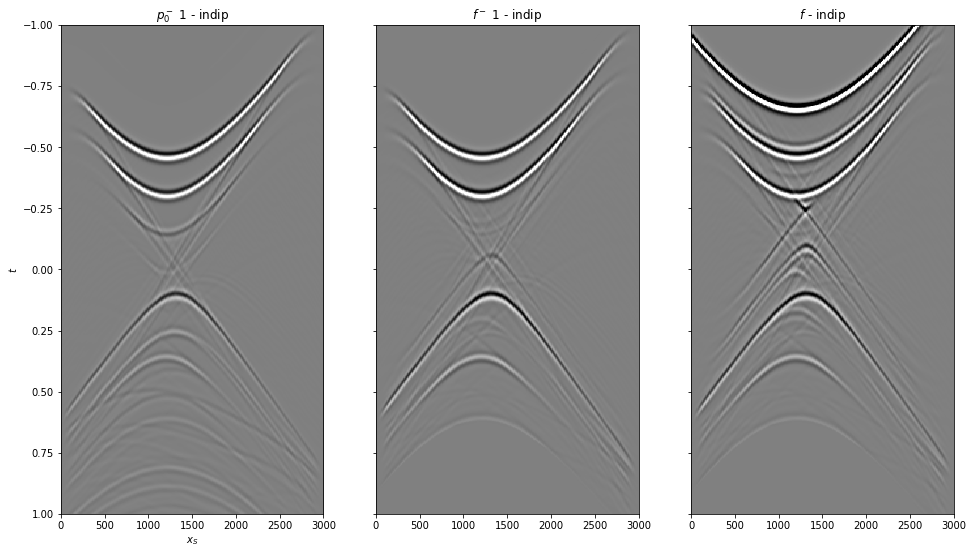

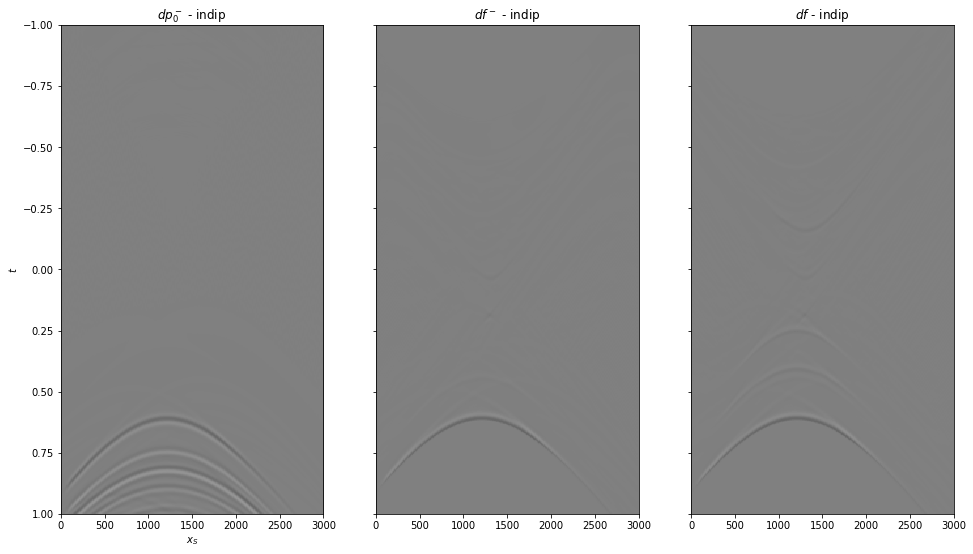

In [15]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_1_minus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ 1 - indip'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_1_minus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - indip'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l2indip.T + f1_1_plus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
plt.savefig('Figures/f_indip.png', dpi=300)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_2_minus_l2indip.T-p0_1_minus_l2indip.T, cmap='gray', 
              vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$dp_0^-$ - indip'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_2_minus_l2indip.T - f1_1_minus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l2indip.T + f1_2_plus_l2indip.T) - (f1_1_minus_l2indip.T + f1_1_plus_l2indip.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - indip'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
plt.savefig('Figures/df_indip.png', dpi=300)

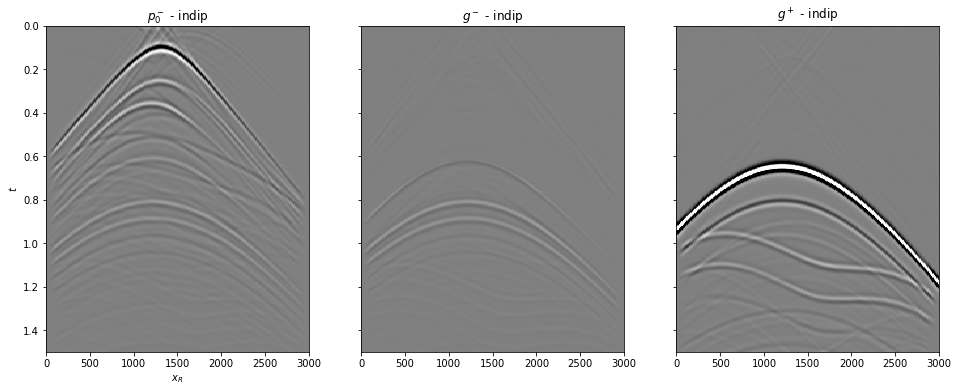

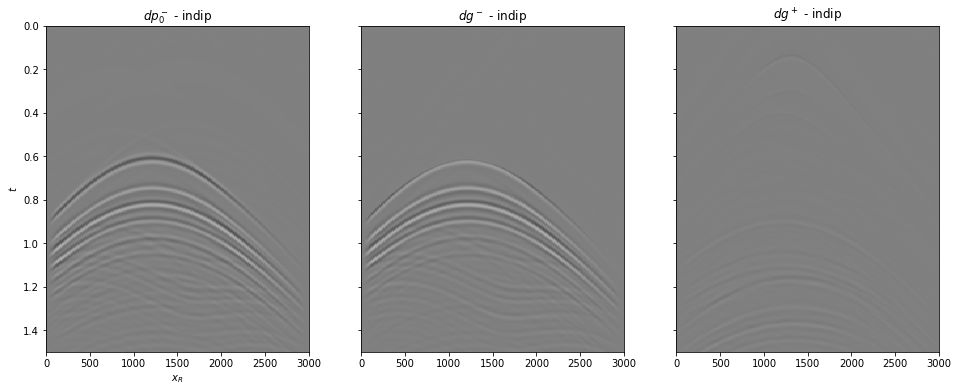

In [16]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ - indip'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$ - indip'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_1_plus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$ - indip'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);
plt.savefig('Figures/g_indip.png', dpi=300)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_2_minus_l2indip.T - p0_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$dp_0^-$ - indip'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_2_minus_l2indip.T - g_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$dg^-$ - indip'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_2_plus_l2indip.T - g_1_plus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$dg^+$ - indip'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);
plt.savefig('Figures/dg_indip.png', dpi=300)

## Joint Marchenko with full sources

In [17]:
SumOp = VStack([HStack([Identity(2*(2*nt-1)*nr), Identity(2*(2*nt-1)*nr), Zero(2*(2*nt-1)*nr)]),
                HStack([Identity(2*(2*nt-1)*nr), Zero(2*(2*nt-1)*nr), Identity(2*(2*nt-1)*nr)])])
Mop = BlockDiag([Mop1, Mop2]) * SumOp
dottest(Mop, 4*ns*(2*nt-1), 6*nr*(2*nt-1), verb=True);

# Data
d = np.concatenate((d1, d2))

# Inverse
f1_l2 = lsqr(Mop, d.flatten(), iter_lim=20, show=True)[0]
f1_l2 = f1_l2.reshape(6*nr, nt2)

Dot test passed, v^T(Opu)=1768.588418 - u^T(Op^Tv)=1768.588418
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1.73744e+06 rows  and 2.60617e+06 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.463e+01  7.463e+01    1.0e+00  2.4e-02
     1  0.00000e+00   3.303e+01  3.303e+01    4.4e-01  9.8e-01   2.0e+00  1.0e+00
     2  0.00000e+00   1.902e+01  1.902e+01    2.5e-01  4.0e-01   3.3e+00  2.2e+00
     3  0.00000e+00   1.494e+01  1.494e+01    2.0e-01  2.8e-01   4.0e+00  3.4e+00
     4  0.00000e+00   1.168e+01  1.168e+01    1.6e-01  2.7e-01   4.6e+00  5.1e+00
     5  0.00000e+00   9.294e+00  9.294e+00    1.2e-01  2.0e-01   5.3e+00  6.9e+00
     6  0.00000e+00   7.913e+00  7.913e+00    1.1e-01  1.7e-01   5.8e+00  8.6e+00
     7  0.00000e+00   6.616e+00  6.616e+0

In [18]:
f1_l2
f1_tot_l2 = f1_l2 + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l2 = f1_tot_l2[:2*nr] + f1_tot_l2[2*nr:4*nr]
f1_2_tot_l2 = f1_tot_l2[:2*nr] + f1_tot_l2[4*nr:]

g_1_tot_l2 = Gop1*f1_1_tot_l2.flatten()
g_1_tot_l2 = g_1_tot_l2.reshape(2*ns, (2*nt-1))
g_2_tot_l2 = Gop2*f1_2_tot_l2.flatten()
g_2_tot_l2 = g_2_tot_l2.reshape(2*ns, (2*nt-1))

f1_1_minus_l2, f1_1_plus_l2 = f1_1_tot_l2[:nr], f1_1_tot_l2[nr:]
f1_2_minus_l2, f1_2_plus_l2 = f1_2_tot_l2[:nr], f1_2_tot_l2[nr:]
g_1_minus_l2, g_1_plus_l2 =  -g_1_tot_l2[:ns], np.fliplr(g_1_tot_l2[ns:])
g_2_minus_l2, g_2_plus_l2 =  -g_2_tot_l2[:ns], np.fliplr(g_2_tot_l2[ns:])

g_1_tot_l2 = g_1_minus_l2 + g_1_plus_l2
g_2_tot_l2 = g_2_minus_l2 + g_2_plus_l2

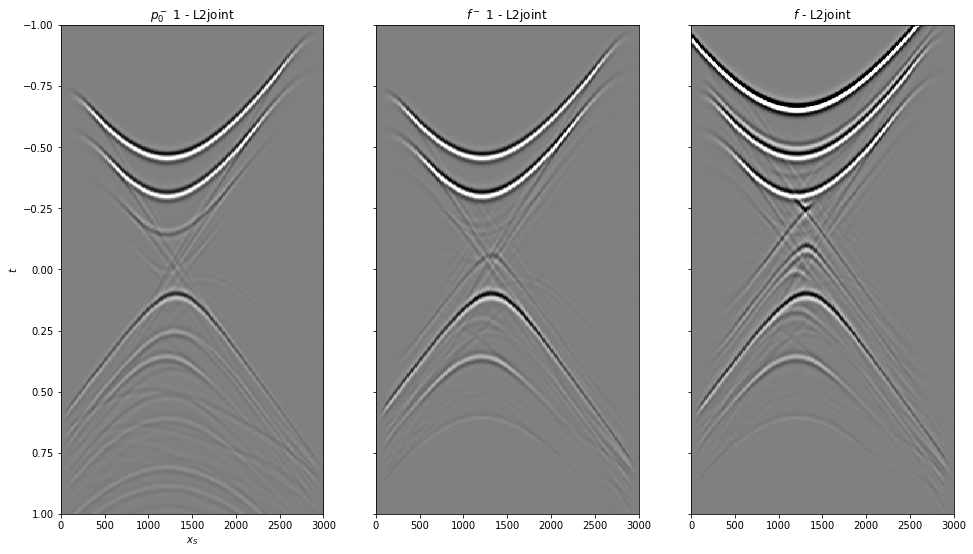

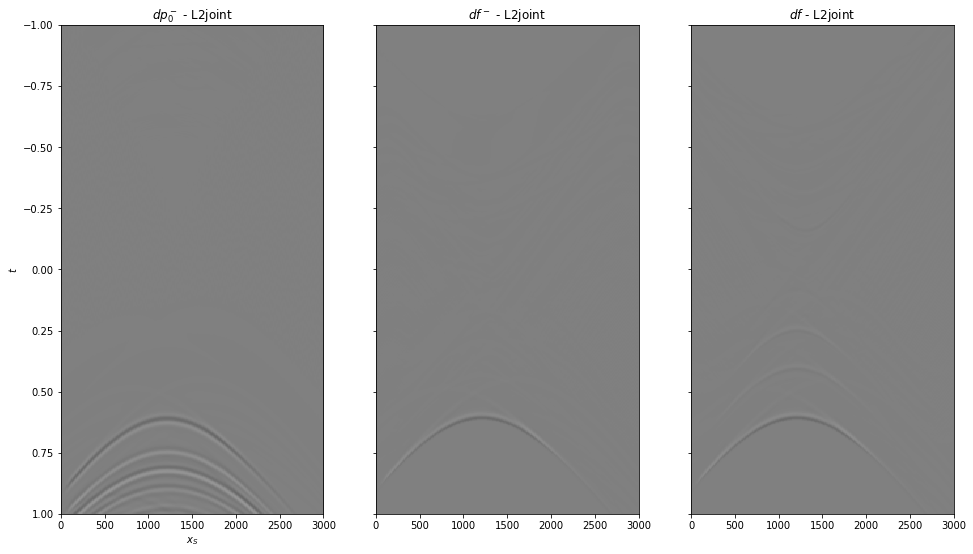

In [19]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_1_minus_l2indip.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ 1 - L2joint'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_1_minus_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L2joint'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l2.T + f1_1_plus_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L2joint'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
plt.savefig('Figures/f_L2joint.png', dpi=300)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_2_minus_l2indip.T-p0_1_minus_l2indip.T, cmap='gray', 
              vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$dp_0^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_2_minus_l2.T - f1_1_minus_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L2joint'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l2.T + f1_2_plus_l2.T) - (f1_1_minus_l2.T + f1_1_plus_l2.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L2joint'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
plt.savefig('Figures/df_L2joint.png', dpi=300);

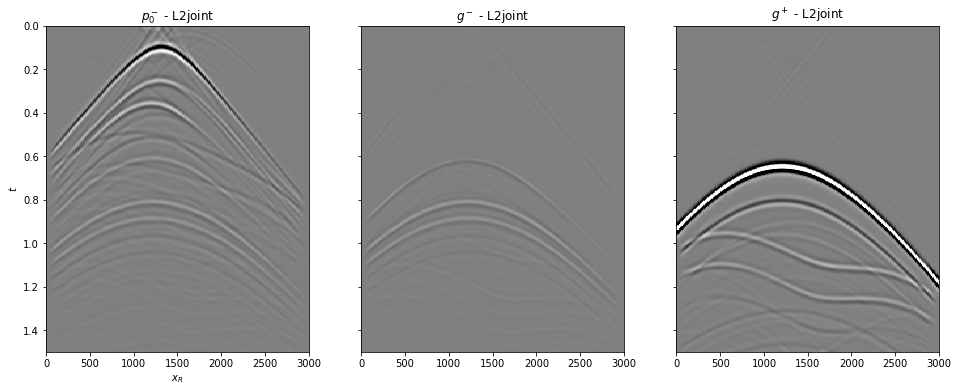

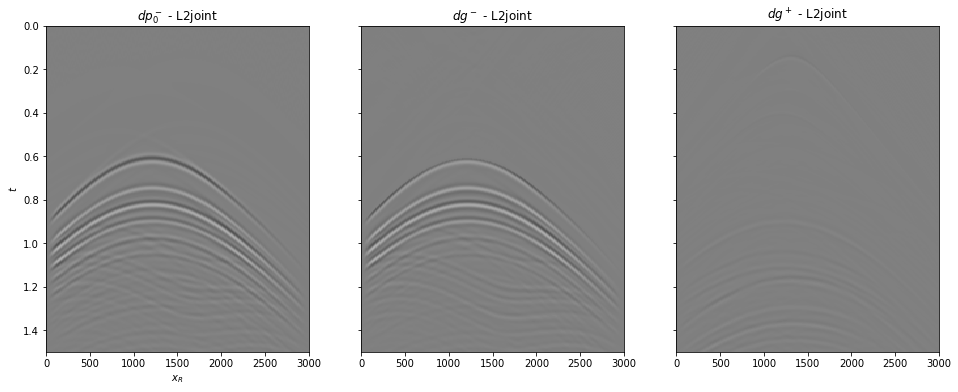

In [20]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_1_minus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_1_plus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$ - L2joint'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0)
plt.savefig('Figures/g_L2joint.png', dpi=300);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_2_minus_l2indip.T - p0_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$dp_0^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0);
axs[1].imshow(g_2_minus_l2.T - g_1_minus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$dg^-$ - L2joint'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].imshow(g_2_plus_l2.T - g_1_plus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$dg^+$ - L2joint'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0)
plt.savefig('Figures/dg_L2joint.png', dpi=300);

## Joint Marchenko with missing sources

In [21]:
iava1 = np.loadtxt(path0 + 'temp_select_rfrac70.dat', delimiter=',', dtype=int) - 1
iava2 = np.loadtxt(path0 + 'temp_select_rfrac50.dat', delimiter=',', dtype=int) - 1
nsava1=iava1.shape[0]
nsava2=iava2.shape[0]
        
Restrop1 = Restriction(ns*(2*nt-1), iava1, dims=(ns, 2*nt-1), dir=0, dtype='float64')
Restrop2 = Restriction(ns*(2*nt-1), iava2, dims=(ns, 2*nt-1), dir=0, dtype='float64')

In [22]:
Rop1 = MDC(Rtwosided_fft_1[iava1], nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
R1op1 = MDC(R1twosided_fft_1[iava1], nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')

Rop2 = MDC(Rtwosided_fft_2[iava2], nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')
R1op2 = MDC(R1twosided_fft_2[iava2], nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, dtype='complex64')

Wop = Diagonal(w.flatten())
WSop1 = Diagonal(w[iava1].flatten())
WSop2 = Diagonal(w[iava2].flatten())

Mop1 = VStack([HStack([Restrop1, -1*WSop1*Rop1]),
               HStack([-1*WSop1*R1op1, Restrop1])])*BlockDiag([Wop, Wop])
Mop2 = VStack([HStack([Restrop2, -1*WSop2*Rop2]),
               HStack([-1*WSop2*R1op2, Restrop2])])*BlockDiag([Wop, Wop])
SumOp = VStack([HStack([Identity(2*(2*nt-1)*nr), Identity(2*(2*nt-1)*nr), Zero(2*(2*nt-1)*nr)]),
                HStack([Identity(2*(2*nt-1)*nr), Zero(2*(2*nt-1)*nr), Identity(2*(2*nt-1)*nr)])])
Mop = BlockDiag([Mop1, Mop2]) * SumOp

Gop1 = VStack([HStack([Restrop1, -1*Rop1]),
               HStack([-1*R1op1, Restrop1])])
Gop2 = VStack([HStack([Restrop2, -1*Rop2]),
               HStack([-1*R1op2, Restrop2])])

# RTM
p0_1_minus_l2sub = Rop1 * fd_plus.flatten()
p0_1_minus_l2sub = p0_1_minus_l2sub.reshape(nsava1, (2*nt-1))

p0_2_minus_l2sub = Rop2 * fd_plus.flatten()
p0_2_minus_l2sub = p0_2_minus_l2sub = Rop2 * fd_plus.flatten()

# Data
d1_sub = WSop1*Rop1*fd_plus.flatten()
d1_sub = np.concatenate((d1_sub.reshape(nsava1, 2*nt-1), np.zeros((nsava1, 2*nt-1))))
d2_sub = WSop2*Rop2*fd_plus.flatten()
d2_sub = np.concatenate((d2_sub.reshape(nsava2, 2*nt-1), np.zeros((nsava2, 2*nt-1))))
d_sub = np.concatenate((d1_sub, d2_sub))

# Inverse
f1_l2sub = lsqr(Mop, d_sub.flatten(), iter_lim=20, show=True)[0]
f1_l2sub = f1_l2sub.reshape(6*nr, nt2)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1.04592e+06 rows  and 2.60617e+06 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.889e+01  5.889e+01    1.0e+00  2.8e-02
     1  0.00000e+00   2.382e+01  2.382e+01    4.0e-01  9.8e-01   1.8e+00  1.0e+00
     2  0.00000e+00   1.306e+01  1.306e+01    2.2e-01  5.0e-01   2.9e+00  2.2e+00
     3  0.00000e+00   8.388e+00  8.388e+00    1.4e-01  3.8e-01   3.6e+00  3.4e+00
     4  0.00000e+00   5.756e+00  5.756e+00    9.8e-02  2.8e-01   4.2e+00  4.8e+00
     5  0.00000e+00   4.252e+00  4.252e+00    7.2e-02  2.6e-01   4.7e+00  6.3e+00
     6  0.00000e+00   2.963e+00  2.963e+00    5.0e-02  2.4e-01   5.2e+00  8.1e+00
     7  0.00000e+00   2.252e+00  2.252e+00    3.8e-02  1.8e-01   5.6e+00  9.8e+00
     8  0.00000e+00   

In [23]:
f1_tot_l2sub = f1_l2sub + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l2sub = f1_tot_l2sub[:2*nr] + f1_tot_l2sub[2*nr:4*nr]
f1_2_tot_l2sub = f1_tot_l2sub[:2*nr] + f1_tot_l2sub[4*nr:]

g_1_l2sub = Gop1*f1_1_tot_l2sub.flatten()
g_1_l2sub = g_1_l2sub.reshape(2*nsava1, (2*nt-1))
g_2_l2sub = Gop2*f1_2_tot_l2sub.flatten()
g_2_l2sub = g_2_l2sub.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l2sub, f1_1_plus_l2sub =  f1_1_tot_l2sub[:nr], f1_1_tot_l2sub[nr:]
f1_2_minus_l2sub, f1_2_plus_l2sub =  f1_2_tot_l2sub[:nr], f1_2_tot_l2sub[nr:]
g_1_minus_l2sub, g_1_plus_l2sub =  -g_1_l2sub[:nsava1], np.fliplr(g_1_l2sub[nsava1:])
g_2_minus_l2sub, g_2_plus_l2sub =  -g_2_l2sub[:nsava2], np.fliplr(g_2_l2sub[nsava2:])

g_1_tot_l2sub = g_1_minus_l2sub + g_1_plus_l2sub
g_2_tot_l2sub = g_2_minus_l2sub + g_2_plus_l2sub

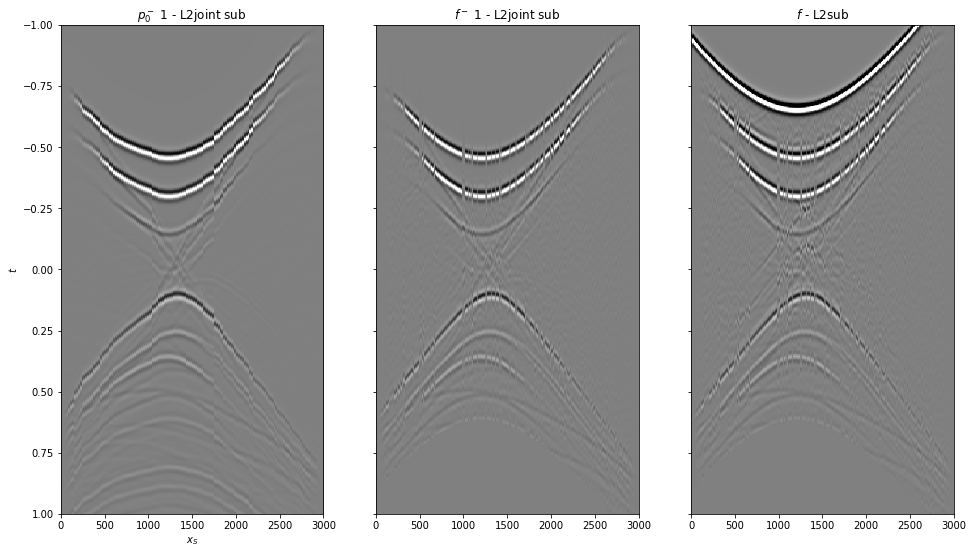

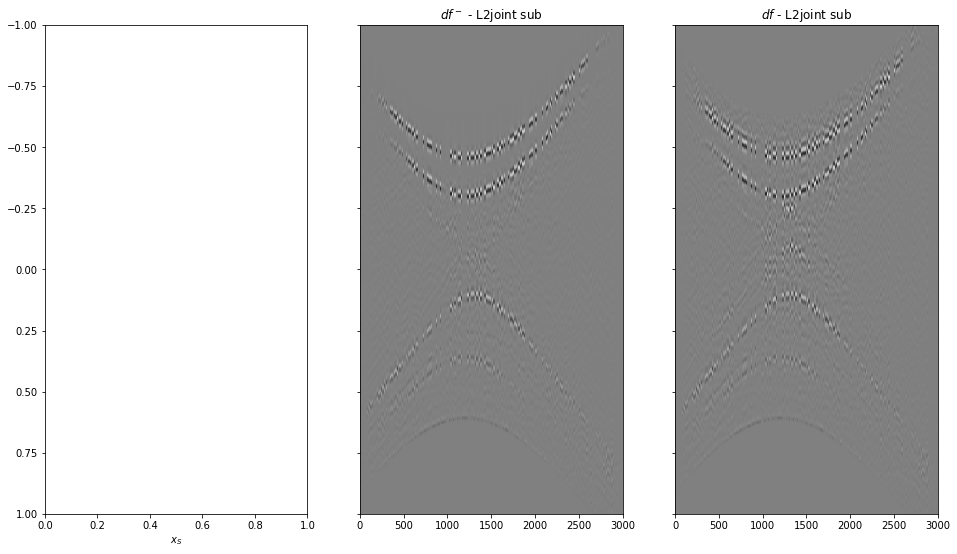

In [24]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_1_minus_l2sub.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$ 1 - L2joint sub'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_1_minus_l2sub.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L2joint sub'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l2sub.T + f1_1_plus_l2sub.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L2sub'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
plt.savefig('Figures/f_L2jointsub.png', dpi=300)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_2_minus_l2sub.T - f1_1_minus_l2sub.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L2joint sub'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l2sub.T + f1_2_plus_l2sub.T) - (f1_1_minus_l2sub.T + f1_1_plus_l2sub.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L2joint sub'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
plt.savefig('Figures/df_L2jointsub.png', dpi=300);

## Marchenko with missing sources and Radon sparsity transform

In [25]:
# Radon transform
nwin=31
nwins=9
nover=10
npx=101
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)

t2=np.concatenate([-t[::-1], t[1:]])
nt2=t2.shape[0]

dimsd = (nr, nt2)
dimss = (nwins*npx, dimsd[1])

# sliding window radon with overlap
RadOp = Radon2D(t2, np.linspace(-ds*nwin//2, ds*nwin//2, nwin), px, centeredh=True, 
                kind='linear', engine='numba')
Slidop = Sliding2D(RadOp, dimss, dimsd, nwin, nover, tapertype='cosine', design=True)
Sparseop = BlockDiag([Slidop, Slidop, Slidop, Slidop])
Sparseop1 = BlockDiag([Slidop, Slidop, Slidop, Slidop, Slidop, Slidop])

Sumop = VStack([HStack([Identity(2*np.prod(dimss)), Identity(2*np.prod(dimss)), Zero(2*np.prod(dimss))]),
                HStack([Identity(2*np.prod(dimss)), Zero(2*np.prod(dimss)), Identity(2*np.prod(dimss))])])

Mop_radon = BlockDiag([Mop1, Mop2]) * Sparseop * Sumop
dottest(Mop_radon, 2*(nsava1+nsava2)*nt2, 6*np.prod(dimss), verb=True);

Dot test passed, v^T(Opu)=-9009.327953 - u^T(Op^Tv)=-9009.327953


Forward and adjoint Radon

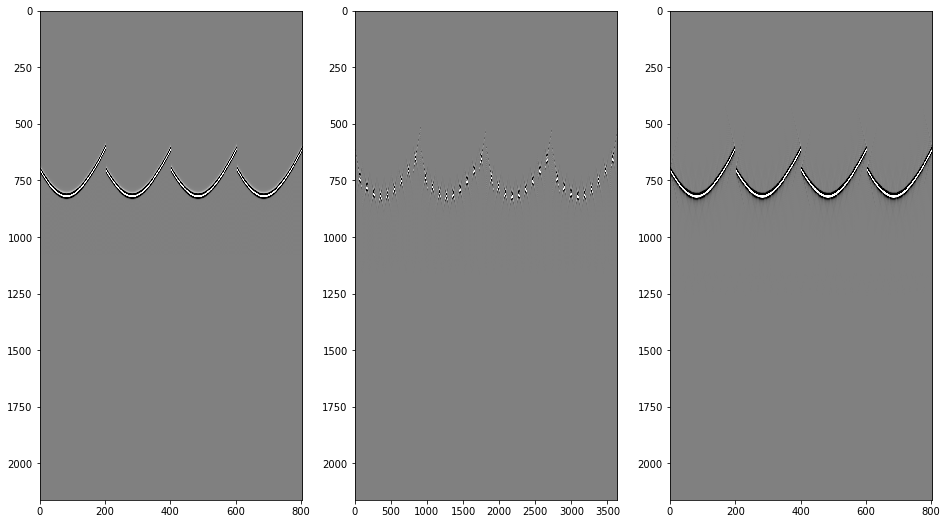

In [26]:
fd_plus1 = np.concatenate([fd_plus, fd_plus, fd_plus, fd_plus])
fd_plus1_radon = Sparseop.H*fd_plus1.flatten()
fd_plus2_radon = Sparseop * fd_plus1_radon

fd_plus1_radon = fd_plus1_radon.reshape(4*npx*nwins, nt2)
fd_plus2_radon = fd_plus2_radon.reshape(4*nr, nt2)

fig, axs = plt.subplots(1, 3, figsize=(16, 9))
axs[0].imshow(fd_plus1.T, cmap='gray', vmin=-5e-1, vmax=5e-1)
axs[0].axis('tight')
axs[1].imshow(fd_plus1_radon.T, cmap='gray', vmin=-5e0, vmax=5e0)
axs[1].axis('tight');
axs[2].imshow(fd_plus2_radon.T, cmap='gray', vmin=-5e1, vmax=5e1)
axs[2].axis('tight');

And on one of the previously found solutions (upgoing focusing function)

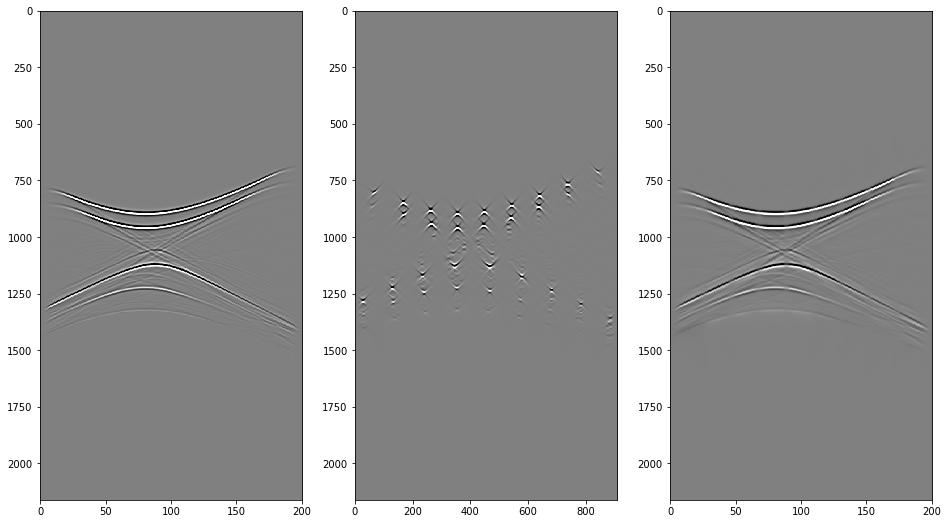

In [27]:
f1_minus_radon = Slidop.H * f1_1_minus_l2.flatten()
f1_minus_rec = Slidop * f1_minus_radon
f1_minus_radon = f1_minus_radon.reshape(npx*nwins, nt2)
f1_minus_rec = f1_minus_rec.reshape(nr, nt2)

fig, axs = plt.subplots(1, 3, figsize=(16, 9))
axs[0].imshow(f1_1_minus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1)
axs[0].axis('tight')
axs[1].imshow(f1_minus_radon.T, cmap='gray', vmin=-5e0, vmax=5e0)
axs[1].axis('tight')
axs[2].imshow(f1_minus_rec.T, cmap='gray', vmin=-1e2, vmax=1e2)
axs[2].axis('tight');

L2 Inversion

In [28]:
f1_l2radon = lsqr(Mop_radon, d_sub.flatten(), iter_lim=n_iter, show=True)[0]
f1_l2radon = Sparseop1 * f1_l2radon
f1_l2radon = f1_l2radon.reshape(6*nr, nt2)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1.04592e+06 rows  and 1.17861e+07 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.889e+01  5.889e+01    1.0e+00  3.1e-01
     1  0.00000e+00   3.190e+01  3.190e+01    5.4e-01  1.0e+00   2.2e+01  1.0e+00
     2  0.00000e+00   2.407e+01  2.407e+01    4.1e-01  5.8e-01   4.3e+01  2.5e+00
     3  0.00000e+00   1.897e+01  1.897e+01    3.2e-01  3.4e-01   6.5e+01  4.4e+00
     4  0.00000e+00   1.565e+01  1.565e+01    2.7e-01  2.6e-01   8.1e+01  6.2e+00
     5  0.00000e+00   1.303e+01  1.303e+01    2.2e-01  2.1e-01   9.5e+01  8.2e+00
     6  0.00000e+00   1.106e+01  1.106e+01    1.9e-01  1.7e-01   1.1e+02  1.0e+01
     7  0.00000e+00   9.635e+00  9.635e+00    1.6e-01  1.5e-01   1.2e+02  1.2e+01
     8  0.00000e+00   

In [29]:
f1_tot_l2radon = f1_l2radon + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l2radon = f1_tot_l2radon[:2*nr] + f1_tot_l2radon[2*nr:4*nr]
f1_2_tot_l2radon = f1_tot_l2radon[:2*nr] + f1_tot_l2radon[4*nr:]

g_1_tot_l2radon = Gop1*f1_1_tot_l2radon.flatten()
g_1_tot_l2radon = g_1_tot_l2radon.reshape(2*nsava1, (2*nt-1))
g_2_tot_l2radon = Gop2*f1_1_tot_l2radon.flatten()
g_2_tot_l2radon = g_2_tot_l2radon.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l2radon, f1_1_plus_l2radon = f1_1_tot_l2radon[:nr], f1_1_tot_l2radon[nr:]
f1_2_minus_l2radon, f1_2_plus_l2radon = f1_2_tot_l2radon[:nr], f1_2_tot_l2radon[nr:]
g_1_minus_l2radon, g_1_plus_l2radon = -g_1_tot_l2radon[:nsava1], np.fliplr(g_1_tot_l2radon[nsava1:])
g_2_minus_l2radon, g_2_plus_l2radon = -g_2_tot_l2radon[:nsava2], np.fliplr(g_2_tot_l2radon[nsava2:])

g_1_tot_l2radon = g_1_minus_l2radon + g_1_plus_l2radon
g_2_tot_l2radon = g_2_minus_l2radon + g_2_plus_l2radon

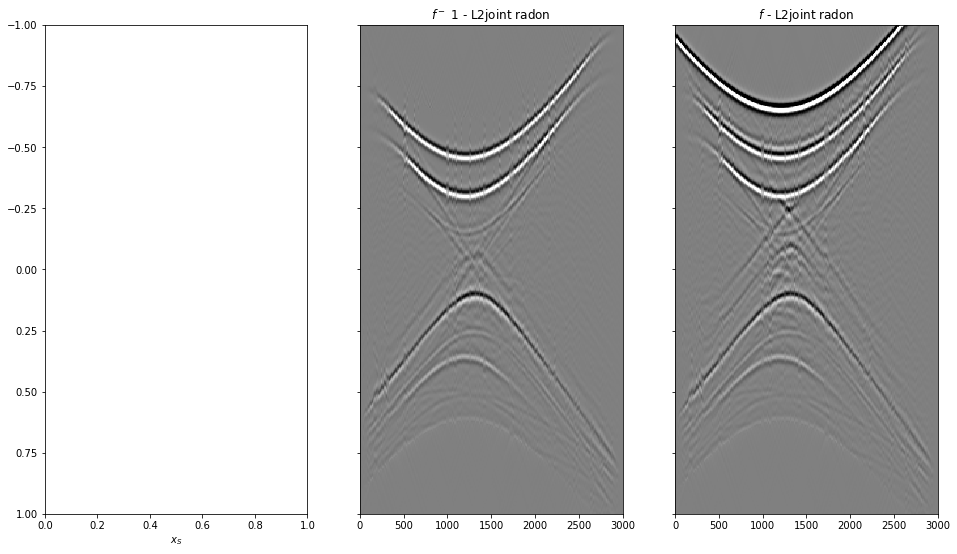

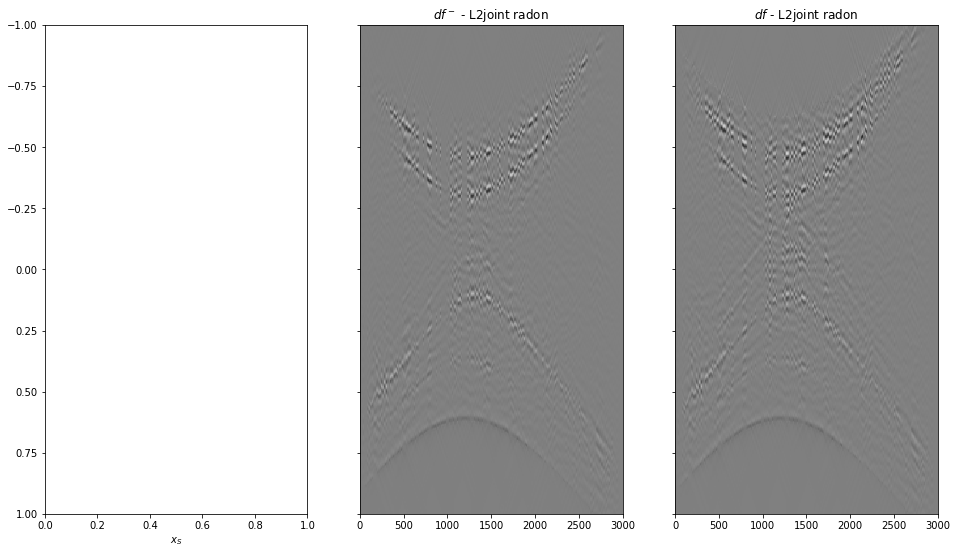

In [30]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_1_minus_l2radon.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L2joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l2radon.T + f1_1_plus_l2radon.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L2joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
plt.savefig('Figures/f_L2jointradon.png', dpi=300)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_2_minus_l2radon.T - f1_1_minus_l2radon.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L2joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l2radon.T + f1_2_plus_l2radon.T) - (f1_1_minus_l2radon.T + f1_1_plus_l2radon.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L2joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
plt.savefig('Figures/df_L2jointradon.png', dpi=300);

Sparse inversion

In [31]:
psnr = []
f1_l1radon = FISTA(Mop_radon, d_sub.flatten(), eps=3e-2, niter=n_iter*2,
                   alpha=2.129944e-04, #eigsiter=4, eigstol=1e-3, 
                   tol=1e-2, returninfo=False, show=True,
                   callback=lambda x: callback(x, f1_l2, Sparseop1, psnr))[0]
f1_l1radon = Sparseop1 * f1_l1radon
f1_l1radon = f1_l1radon.reshape(6*nr, nt2)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 1045924 rows and 11786094 cols
eps = 3.000000e-02	tol = 1.000000e-02	niter = 200
alpha = 2.129944e-04	thresh = 3.194916e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   1.499e+03   1.502e+03   2.290e-01
     2   0.00000e+00   1.307e+03   1.313e+03   2.063e-01
     3   0.00000e+00   1.105e+03   1.115e+03   2.403e-01
     4   0.00000e+00   9.110e+02   9.240e+02   2.623e-01
     5   0.00000e+00   7.344e+02   7.510e+02   2.743e-01
     6   0.00000e+00   5.811e+02   6.013e+02   2.778e-01
     7   0.00000e+00   4.531e+02   4.769e+02   2.745e-01
     8   0.00000e+00   3.496e+02   3.768e+02   2.659e-01
     9   0.00000e+00   2.682e+02   2.986e+02   2.535e-01
    10   0.00000e+00   2.057e+02   2.391e+02   2.383e-01
    11   0.00000e+00   1.586e+02   1.947e+02   2.216e-01
    21   0.00

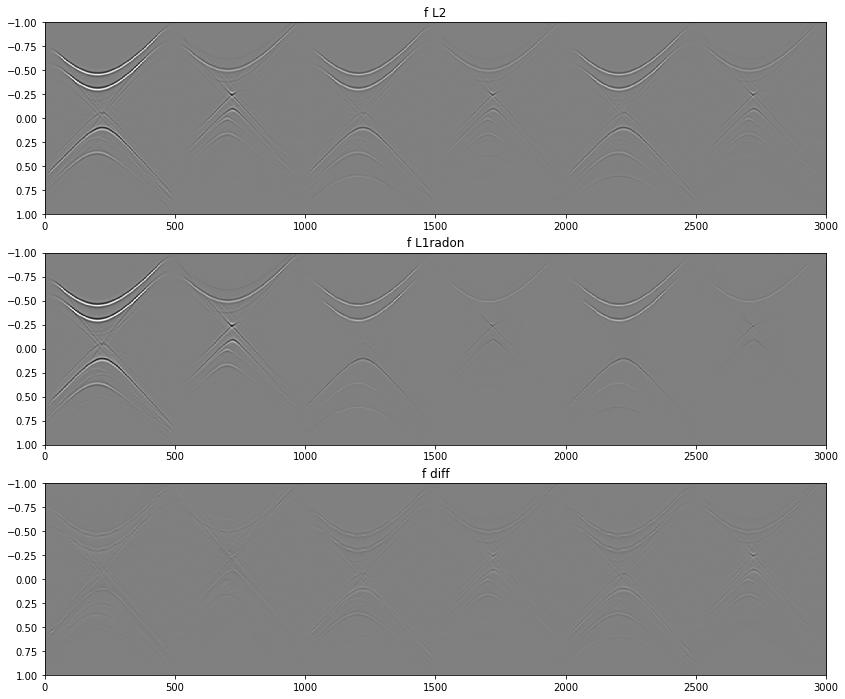

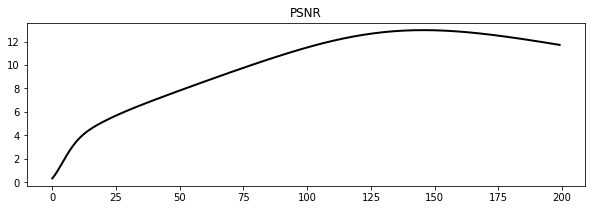

In [32]:
fig, axs = plt.subplots(3, 1, figsize=(14, 12))
axs[0].imshow(f1_l2.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].axis('tight')
axs[0].set_title('f L2')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].axis('tight')
axs[1].set_title('f L1radon')
axs[1].set_ylim(1, -1)
axs[2].imshow(f1_l2.T - f1_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].axis('tight')
axs[2].set_title('f diff')
axs[2].set_ylim(1, -1);

In [35]:
f1_tot_l1radon = f1_l1radon + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l1radon = f1_tot_l1radon[:2*nr] + f1_tot_l1radon[2*nr:4*nr]
f1_2_tot_l1radon = f1_tot_l1radon[:2*nr] + f1_tot_l1radon[4*nr:]

g_1_tot_l1radon = Gop1*f1_1_tot_l1radon.flatten()
g_1_tot_l1radon = g_1_tot_l1radon.reshape(2*nsava1, (2*nt-1))
g_2_tot_l1radon = Gop2*f1_1_tot_l1radon.flatten()
g_2_tot_l1radon = g_2_tot_l1radon.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l1radon, f1_1_plus_l1radon = f1_1_tot_l1radon[:nr], f1_1_tot_l1radon[nr:]
f1_2_minus_l1radon, f1_2_plus_l1radon = f1_2_tot_l1radon[:nr], f1_2_tot_l1radon[nr:]
g_1_minus_l1radon, g_1_plus_l1radon = -g_1_tot_l1radon[:nsava1], np.fliplr(g_1_tot_l1radon[nsava1:])
g_2_minus_l1radon, g_2_plus_l1radon = -g_2_tot_l1radon[:nsava2], np.fliplr(g_2_tot_l1radon[nsava2:])

g_1_tot_l1radon = g_1_minus_l1radon + g_1_plus_l1radon
g_2_tot_l1radon = g_2_minus_l1radon + g_2_plus_l1radon

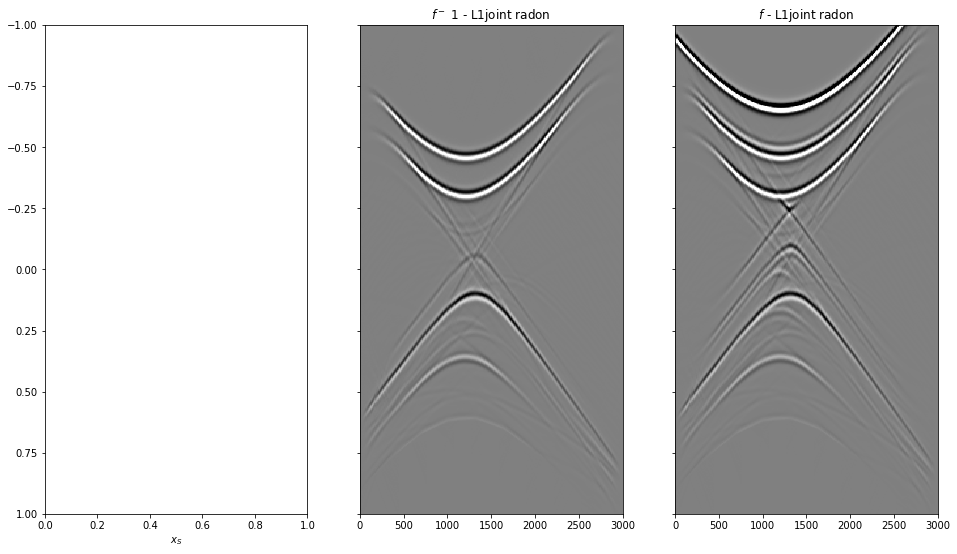

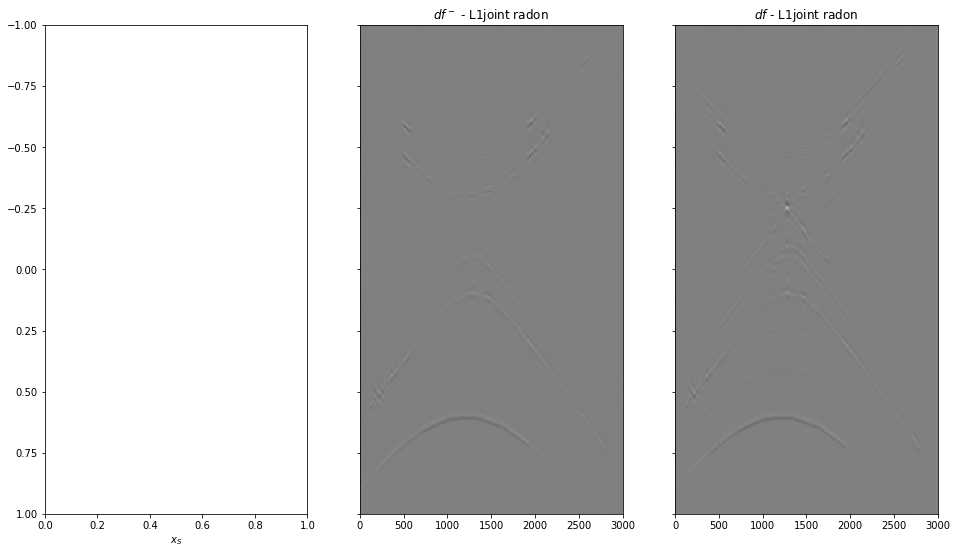

In [36]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_1_minus_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_1_minus_l1radon.T + f1_1_plus_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
plt.savefig('Figures/f_L1jointradon.png', dpi=300)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_2_minus_l1radon.T - f1_1_minus_l1radon.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow((f1_2_minus_l1radon.T + f1_2_plus_l1radon.T) - (f1_1_minus_l1radon.T + f1_1_plus_l1radon.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L1joint radon'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
plt.savefig('Figures/df_L1jointradon.png', dpi=300);

Compare with benchmark focusing functions (from regularly sampled data)

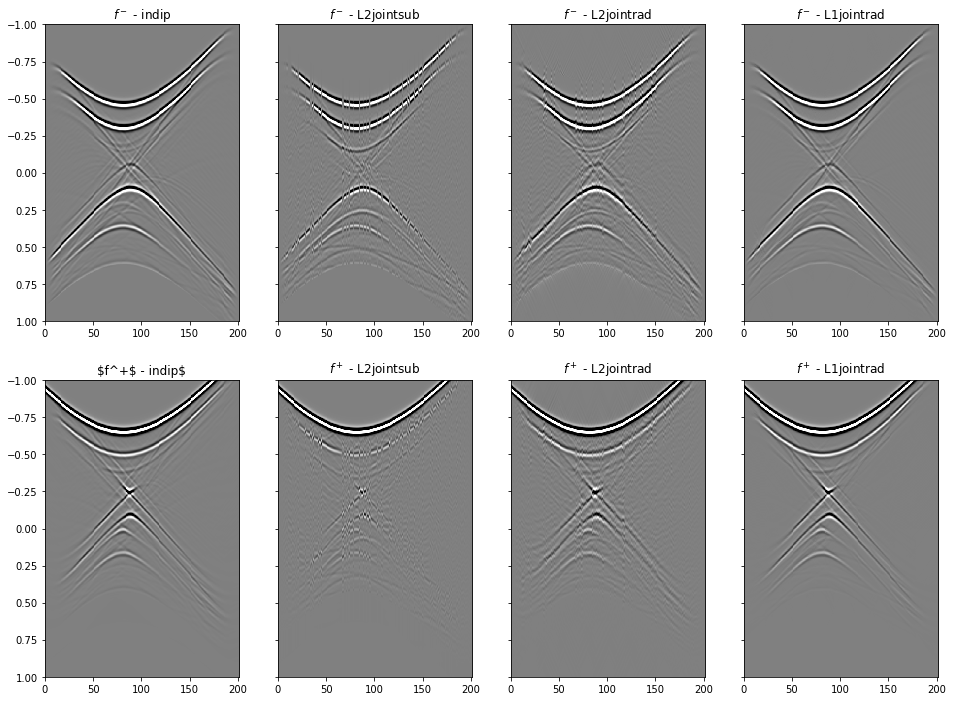

In [37]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(16, 12))
axs[0][0].imshow(f1_1_minus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][0].set_title(r'$f^-$ - indip')
axs[0][0].axis('tight')
axs[0][0].set_ylim(1, -1);
axs[0][1].imshow(f1_1_minus_l2sub.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][1].set_title(r'$f^-$ - L2jointsub')
axs[0][1].axis('tight')
axs[0][1].set_ylim(1, -1)
axs[0][2].imshow(f1_1_minus_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][2].set_title(r'$f^-$ - L2jointrad')
axs[0][2].axis('tight')
axs[0][2].set_ylim(1, -1)
axs[0][3].imshow(f1_1_minus_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0][3].set_title(r'$f^-$ - L1jointrad')
axs[0][3].axis('tight')
axs[0][3].set_ylim(1, -1)
axs[1][0].imshow(f1_1_plus_l2indip.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][0].set_title(r'$f^+$ - indip$')
axs[1][0].axis('tight')
axs[1][0].set_ylim(1, -1);
axs[1][1].imshow(f1_1_plus_l2sub.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][1].set_title(r'$f^+$ - L2jointsub')
axs[1][1].axis('tight')
axs[1][1].set_ylim(1, -1);
axs[1][2].imshow(f1_1_plus_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][2].set_title(r'$f^+$ - L2jointrad')
axs[1][2].axis('tight')
axs[1][2].set_ylim(1, -1);
axs[1][3].imshow(f1_1_plus_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1][3].set_title(r'$f^+$ - L1jointrad')
axs[1][3].axis('tight')
axs[1][3].set_ylim(1, -1);

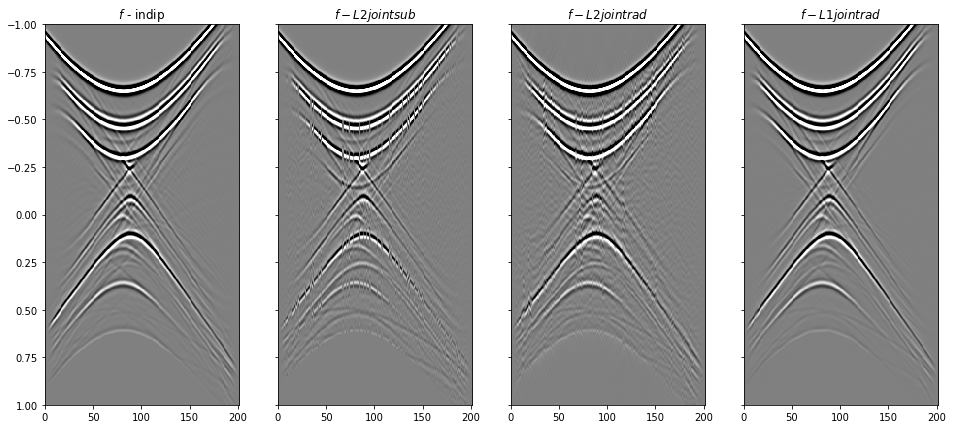

In [38]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 7))
axs[0].imshow(f1_1_minus_l2indip.T + f1_1_plus_l2indip.T, cmap='gray',
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$f$ - indip')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_1_minus_l2sub.T + f1_1_plus_l2indip.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1].set_title(r'$f - L2jointsub$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1)
axs[2].imshow(f1_1_minus_l2radon.T + f1_1_plus_l2radon.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$f - L2jointrad$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
axs[3].imshow(f1_1_minus_l1radon.T + f1_1_plus_l1radon.T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr, t[-1], -t[-1]))
axs[3].set_title(r'$f - L1jointrad$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);

Finally we compare the GF's estimates

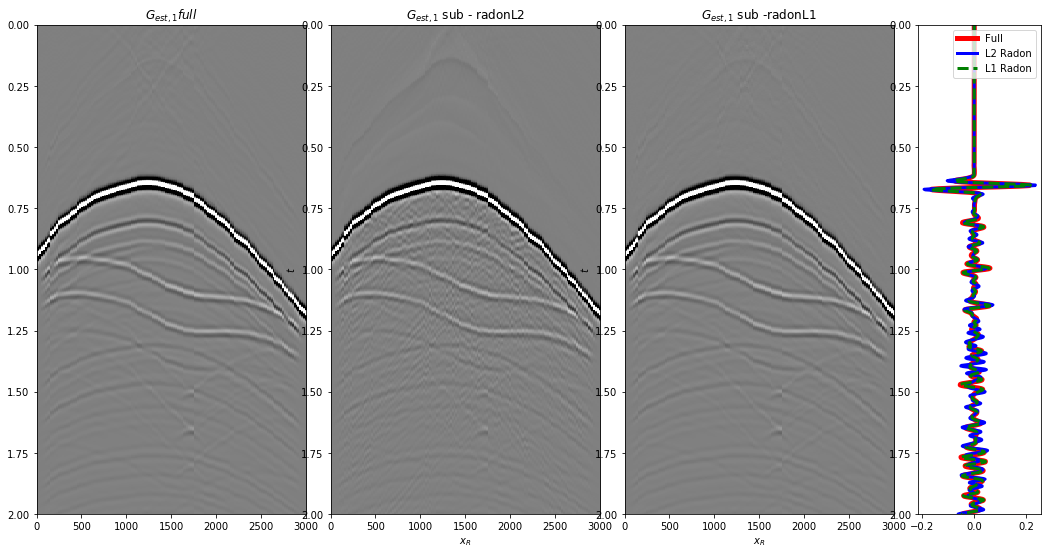

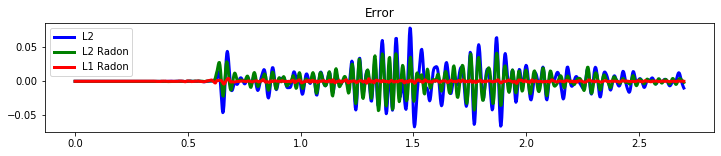

In [41]:
fig = plt.figure(figsize=(18,9))
ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 7), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 7), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 7), (0, 6))

ax1.imshow(g_1_tot_l2[iava1].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.set_title(r'$G_{est,1} full $'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_1_tot_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est,1}$ sub - radonL2'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)
ax3.imshow(g_1_tot_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est,1}$ sub -radonL1'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(2, 0)
ax4.plot(t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max(), t, 'r', lw=5, label='Full')
ax4.plot(t**3*g_1_tot_l2radon[nr//4, nt-1:]/g_1_tot_l2.max(), t, 'b', lw=3, label='L2 Radon')
ax4.plot(t**3*g_1_tot_l1radon[nr//4, nt-1:]/g_1_tot_l2.max(), t, '--g', lw=3, label='L1 Radon')
ax4.set_ylim(2, 0)
ax4.legend()

plt.figure(figsize=(12, 2))
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l2sub[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'b', lw=3, label='L2')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l2radon[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'g', lw=3, label='L2 Radon')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l1radon[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'r', lw=3, label='L1 Radon')
plt.title('Error')
plt.legend();

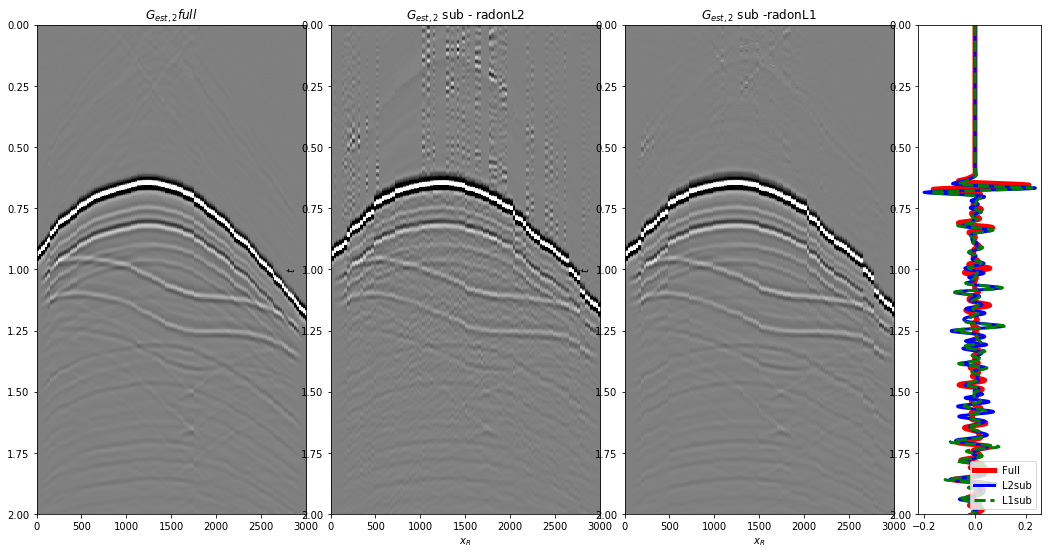

In [42]:
fig = plt.figure(figsize=(18,9))
ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 7), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 7), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 7), (0, 6))

ax1.imshow(g_2_tot_l2[iava1].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.set_title(r'$G_{est,2} full $'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_2_tot_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est,2}$ sub - radonL2'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)
ax3.imshow(g_2_tot_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est,2}$ sub -radonL1'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(2, 0)
ax4.plot(t**3*g_2_tot_l2[iava1][nr//4, nt-1:]/g_2_tot_l2.max(), t, 'r', lw=5, label='Full')
ax4.plot(t**3*g_2_tot_l2radon[nr//4, nt-1:]/g_2_tot_l2.max(), t, 'b', lw=3, label='L2sub')
ax4.plot(t**3*g_2_tot_l1radon[nr//4, nt-1:]/g_2_tot_l2.max(), t, '--g', lw=3, label='L1sub')
ax4.set_ylim(2, 0);
ax4.legend();

# Cannot check the error because of the shift in the estimate due to the fact that the direct wave is 
# made using the baseline velocity model..

Finally we try with an early stopping and see how the results compare

In [43]:
psnr_early = []
f1_l1radon_early = FISTA(Mop_radon, d_sub.flatten(), eps=1e-1, niter=50,
                   alpha=2.129944e-04, #eigsiter=4, eigstol=1e-3, 
                   tol=1e-2, returninfo=False, show=True,
                   callback=lambda x: callback(x, f1_l2, Sparseop1, psnr_early))[0]
f1_l1radon_early = Sparseop1 * f1_l1radon_early
f1_l1radon_early = f1_l1radon_early.reshape(6*nr, nt2)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 1045924 rows and 11786094 cols
eps = 1.000000e-01	tol = 1.000000e-02	niter = 50
alpha = 2.129944e-04	thresh = 1.064972e-05
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   1.502e+03   1.512e+03   2.256e-01
     2   0.00000e+00   1.313e+03   1.331e+03   2.034e-01
     3   0.00000e+00   1.113e+03   1.141e+03   2.370e-01
     4   0.00000e+00   9.208e+02   9.587e+02   2.589e-01
     5   0.00000e+00   7.452e+02   7.936e+02   2.707e-01
     6   0.00000e+00   5.924e+02   6.512e+02   2.742e-01
     7   0.00000e+00   4.643e+02   5.332e+02   2.710e-01
     8   0.00000e+00   3.604e+02   4.386e+02   2.625e-01
     9   0.00000e+00   2.783e+02   3.653e+02   2.502e-01
    10   0.00000e+00   2.149e+02   3.098e+02   2.352e-01
    11   0.00000e+00   1.668e+02   2.690e+02   2.186e-01
    21   0.000

In [44]:
f1_tot_l1radon_early = f1_l1radon_early + np.concatenate((np.zeros((nr, 2*nt-1)), fd_plus, np.zeros((4*nr, 2*nt-1))))

f1_1_tot_l1radon_early = f1_tot_l1radon_early[:2*nr] + f1_tot_l1radon_early[2*nr:4*nr]
f1_2_tot_l1radon_early = f1_tot_l1radon_early[:2*nr] + f1_tot_l1radon_early[4*nr:]

g_1_tot_l1radon_early = Gop1*f1_1_tot_l1radon_early.flatten()
g_1_tot_l1radon_early = g_1_tot_l1radon_early.reshape(2*nsava1, (2*nt-1))
g_2_tot_l1radon_early = Gop2*f1_1_tot_l1radon_early.flatten()
g_2_tot_l1radon_early = g_2_tot_l1radon_early.reshape(2*nsava2, (2*nt-1))

f1_1_minus_l1radon_early, f1_1_plus_l1radon_early = f1_1_tot_l1radon_early[:nr], f1_1_tot_l1radon_early[nr:]
f1_2_minus_l1radon_early, f1_2_plus_l1radon_early = f1_2_tot_l1radon_early[:nr], f1_2_tot_l1radon_early[nr:]
g_1_minus_l1radon_early, g_1_plus_l1radon_early = -g_1_tot_l1radon_early[:nsava1], np.fliplr(g_1_tot_l1radon_early[nsava1:])
g_2_minus_l1radon_early, g_2_plus_l1radon_early = -g_2_tot_l1radon_early[:nsava2], np.fliplr(g_2_tot_l1radon_early[nsava2:])

g_1_tot_l1radon_early = g_1_minus_l1radon_early + g_1_plus_l1radon_early
g_2_tot_l1radon_early = g_2_minus_l1radon_early + g_2_plus_l1radon_early

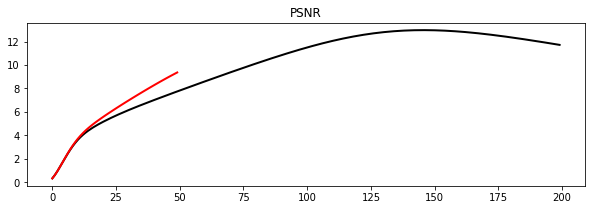

In [45]:
plt.figure(figsize=(10, 3))
plt.plot(psnr, 'k', lw=2)
plt.plot(psnr_early, 'r', lw=2)
plt.title('PSNR');

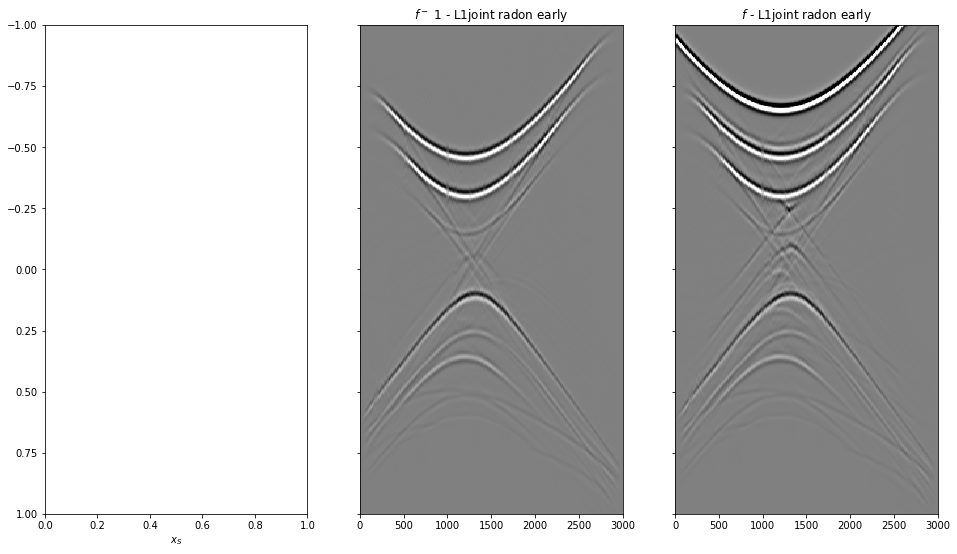

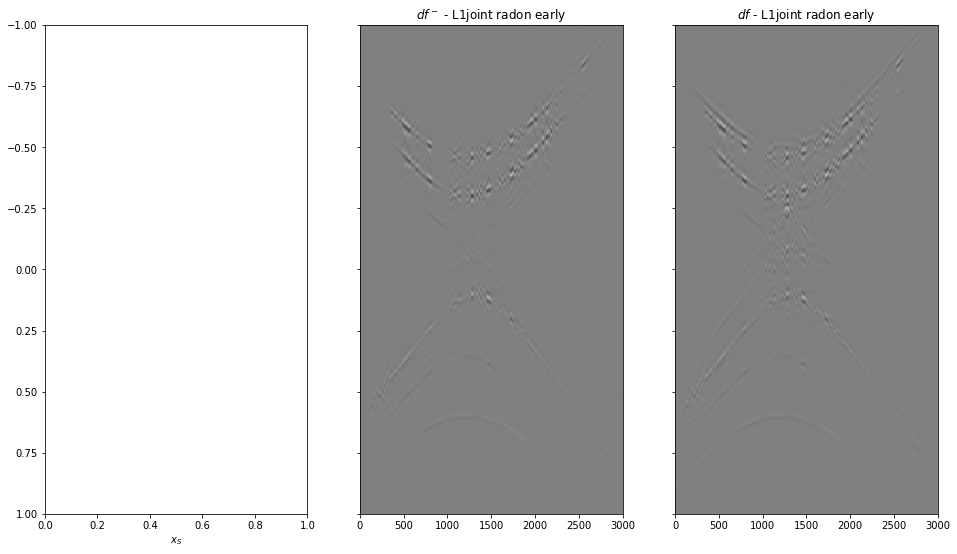

In [46]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_1_minus_l1radon_early.T, cmap='gray', vmin=-1e0, vmax=1e0, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ 1 - L1joint radon early'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1)
axs[2].imshow(f1_1_minus_l1radon_early.T + f1_1_plus_l1radon_early.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f$ - L1joint radon early'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
plt.savefig('Figures/f_L1jointradonearly.png', dpi=300)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[1].imshow(f1_2_minus_l1radon_early.T - f1_1_minus_l1radon_early.T, cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$df^-$ - L1joint radon early'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1)
axs[2].imshow((f1_2_minus_l1radon_early.T + f1_2_plus_l1radon_early.T) - 
              (f1_1_minus_l1radon_early.T + f1_1_plus_l1radon_early.T), 
              cmap='gray', vmin=-1e0, vmax=1e0, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$df$ - L1joint radon early'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
plt.savefig('Figures/df_L1jointradonearly.png', dpi=300);

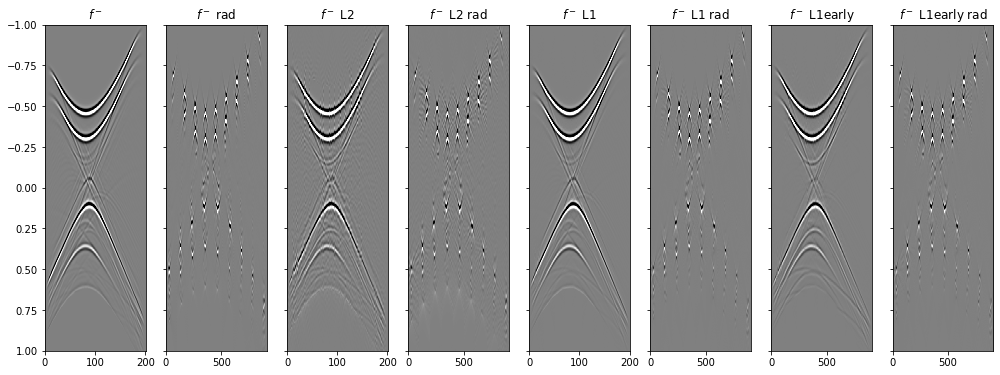

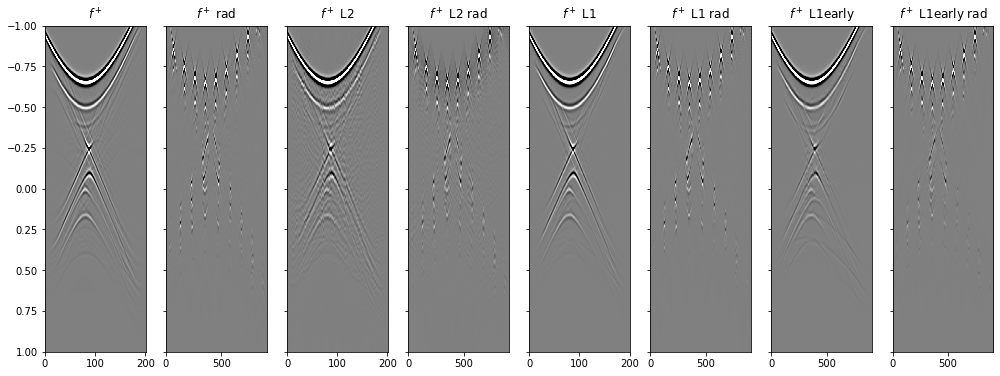

In [49]:
f1_1_minus_l2_radon = Slidop.H * f1_1_minus_l2.flatten()
f1_1_minus_l2_radon = f1_1_minus_l2_radon.reshape(npx*nwins, nt2)
f1_1_minus_l2radon_radon = Slidop.H * f1_1_minus_l2radon.flatten()
f1_1_minus_l2radon_radon = f1_1_minus_l2radon_radon.reshape(npx*nwins, nt2)
f1_1_minus_l1radon_radon = Slidop.H * f1_1_minus_l1radon.flatten()
f1_1_minus_l1radon_radon = f1_1_minus_l1radon_radon.reshape(npx*nwins, nt2)
f1_1_minus_l1radon_early_radon = Slidop.H * f1_1_minus_l1radon_early.flatten()
f1_1_minus_l1radon_early_radon = f1_1_minus_l1radon_early_radon.reshape(npx*nwins, nt2)

f1_1_plus_l2_radon = Slidop.H * f1_1_plus_l2.flatten()
f1_1_plus_l2_radon = f1_1_plus_l2_radon.reshape(npx*nwins, nt2)
f1_1_plus_l2radon_radon = Slidop.H * f1_1_plus_l2radon.flatten()
f1_1_plus_l2radon_radon = f1_1_plus_l2radon_radon.reshape(npx*nwins, nt2)
f1_1_plus_l1radon_radon = Slidop.H * f1_1_plus_l1radon.flatten()
f1_1_plus_l1radon_radon = f1_1_plus_l1radon_radon.reshape(npx*nwins, nt2)
f1_1_plus_l1radon_early_radon = Slidop.H * f1_1_plus_l1radon_early.flatten()
f1_1_plus_l1radon_early_radon = f1_1_plus_l1radon_early_radon.reshape(npx*nwins, nt2)

fig, axs = plt.subplots(1, 8, sharey=True, figsize=(17, 6))
axs[0].imshow(f1_1_minus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$f^-$')
axs[0].axis('tight')
axs[1].imshow(f1_1_minus_l2_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$ rad')
axs[1].axis('tight');
axs[2].imshow(f1_1_minus_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, nr, t[-1], -t[-1]))
axs[2].axis('tight')
axs[2].set_title(r'$f^-$ L2')
axs[3].imshow(f1_1_minus_l2radon_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[3].axis('tight')
axs[3].set_title(r'$f^-$ L2 rad')
axs[3].set_ylim(1, -1);
axs[4].imshow(f1_1_minus_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, nr, t[-1], -t[-1]))
axs[4].axis('tight')
axs[4].set_title(r'$f^-$ L1')
axs[5].imshow(f1_1_minus_l1radon_early_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[5].axis('tight')
axs[5].set_title(r'$f^-$ L1 rad')
axs[5].set_ylim(1, -1)
axs[6].imshow(f1_1_minus_l1radon_early.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[6].axis('tight')
axs[6].set_title(r'$f^-$ L1early')
axs[5].set_ylim(1, -1)
axs[7].imshow(f1_1_minus_l1radon_early_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[7].axis('tight')
axs[7].set_title(r'$f^-$ L1early rad')
axs[7].set_ylim(1, -1);

fig, axs = plt.subplots(1, 8, sharey=True, figsize=(17, 6))
axs[0].imshow(f1_1_plus_l2.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$f^+$')
axs[0].axis('tight')
axs[1].imshow(f1_1_plus_l2_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[1].set_title(r'$f^+$ rad')
axs[1].axis('tight');
axs[2].imshow(f1_1_plus_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$ L2')
axs[2].axis('tight')
axs[3].imshow(f1_1_plus_l2radon_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[3].axis('tight')
axs[3].set_title(r'$f^+$ L2 rad')
axs[3].set_ylim(1, -1);
axs[4].imshow(f1_1_plus_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, nr, t[-1], -t[-1]))
axs[4].set_title(r'$f^+$ L1')
axs[4].axis('tight')
axs[5].imshow(f1_1_plus_l1radon_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[5].axis('tight')
axs[5].set_title(r'$f^+$ L1 rad')
axs[5].set_ylim(1, -1)
axs[6].imshow(f1_1_plus_l1radon_early.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[6].axis('tight')
axs[6].set_title(r'$f^+$ L1early')
axs[5].set_ylim(1, -1)
axs[7].imshow(f1_1_plus_l1radon_early_radon.T, cmap='gray', vmin=-5e0, vmax=5e0, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[7].axis('tight')
axs[7].set_title(r'$f^+$ L1early rad')
axs[7].set_ylim(1, -1);

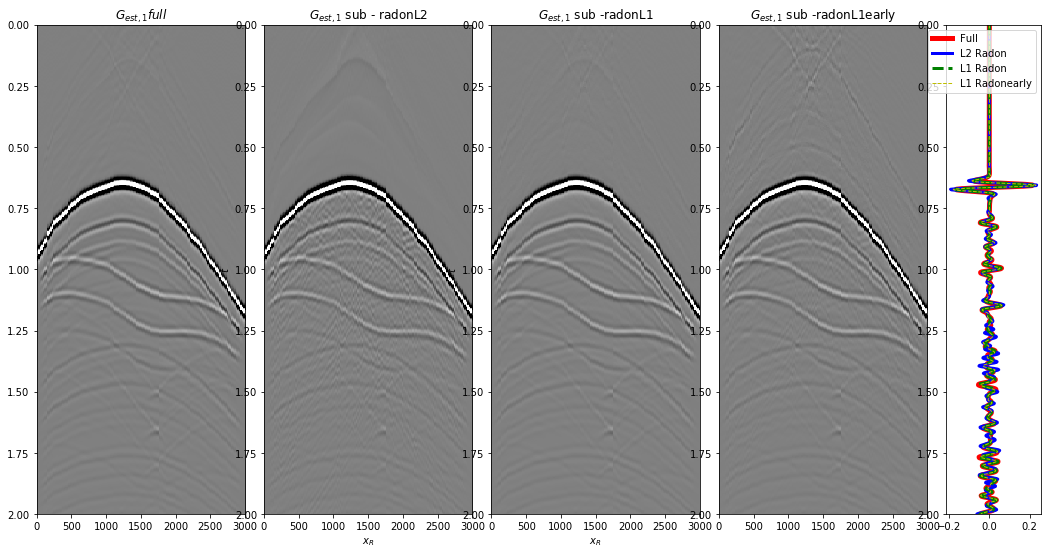

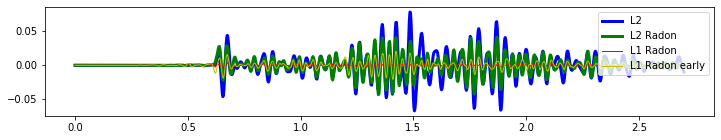

In [50]:
fig = plt.figure(figsize=(18,9))
ax1 = plt.subplot2grid((1, 9), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 9), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 9), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 9), (0, 6), colspan=2)
ax5 = plt.subplot2grid((1, 9), (0, 8))

ax1.imshow(g_1_tot_l2[iava1].T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax1.set_title(r'$G_{est,1} full $'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_1_tot_l2radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est,1}$ sub - radonL2'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)
ax3.imshow(g_1_tot_l1radon.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est,1}$ sub -radonL1'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(2, 0)
ax4.imshow(g_1_tot_l1radon_early.T, cmap='gray', vmin=-5e-1, vmax=5e-1, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax4.set_title(r'$G_{est,1}$ sub -radonL1early'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax4.axis('tight')
ax4.set_ylim(2, 0)
ax5.plot(t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max(), t, 'r', lw=5, label='Full')
ax5.plot(t**3*g_1_tot_l2radon[nr//4, nt-1:]/g_1_tot_l2.max(), t, 'b', lw=3, label='L2 Radon')
ax5.plot(t**3*g_1_tot_l1radon[nr//4, nt-1:]/g_1_tot_l2.max(), t, '--g', lw=3, label='L1 Radon')
ax5.plot(t**3*g_1_tot_l1radon_early[nr//4, nt-1:]/g_1_tot_l2.max(), t, '--y', lw=1, label='L1 Radonearly')
ax5.set_ylim(2, 0)
ax5.legend()

plt.figure(figsize=(12, 2))
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l2sub[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'b', lw=3, label='L2')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l2radon[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'g', lw=3, label='L2 Radon')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l1radon[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'r', lw=1, label='L1 Radon')
plt.plot(t, t**3*g_1_tot_l2[iava1][nr//4, nt-1:]/g_1_tot_l2.max() - t**3*g_1_tot_l1radon_early[nr//4, nt-1:]/g_1_tot_l2.max(), 
         'y', lw=1, label='L1 Radon early')
plt.legend();